Homework 3: Sod's Shock Tube - Bryssinck Paul & de Becker Alexandre


Le but de ce devoir est d'utiliser la méthode de Richtmyer afin de calculer la pression, la vitesse ainsi que la densité d'un gaz le long d'un tube à choc au cours du temps. 

Avant tout, commençons par préparer tout les outils dont nous aurons besoin.

In [1]:
import numpy as np                      
from matplotlib import pyplot    
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

Nous introduisons les données de départ

In [2]:
temps_final=0.01
nx = 81
dx = .25
dt = .0002
nt= int(temps_final/dt)
gamma = 1.4 
L=20

où nx est le nombre de segments en lesquels nous coupons notre tuyau, dx est le pas de distance utilisé en mètre, dt est le pas de temps utilisé en seconde, nt est le nombre d'intervalle de temps (calculé à partir du temps final et de dt), gamma est une constante dans l'équantion d'état d'un gaz idéal, ici la valeur est de 1,4 car nous utilisons de l'air et enfin L est la taille de notre tuyau.    

Nous pouvons à présent commencer les calculs.

Partons de 3 équations d'Euler pour un fluide de densité $\rho$, à pression p avec une vitesse u selon l'axe des x et une énergie par unité de masse $e_T$. Nous avons:

$\frac{\partial \rho}{\partial t}+ \frac{\partial}{\partial x}(\rho u) =0$

$\frac{\partial }{\partial t}(\rho u)+ \frac{\partial}{\partial x}(\rho u^2 +p) =0$

$\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x}(\rho u e_T + pu) =0$

Vu que les trois équations précédentes sont de la même forme, nous pouvons réécrire celles-ci sous la forme suivante:

$\frac{\partial }{\partial t}\vec{u}+ \frac{\partial}{\partial x}\vec{f} =0$

Où $\vec{u}$ et $\vec{f}$ sont des vecteurs définis respectivement par 
$\begin{pmatrix}
   \rho \\
   \rho u \\
   \rho e_T
\end{pmatrix}$ 
et 
$\begin{pmatrix}
   \rho u\\
   \rho u^2+p \\
   \rho u e_T+pu
\end{pmatrix}$


Nous avons un problème qui est que nous avons 4 inconnues pour seulement 3 équations. Nous pouvons résoudre se problème à l'aide de la relation suivante pour la pression:


$p=(\gamma-1)(u_3-\frac{1}{2}\frac{u^2_2}{u_1})$ où $u_1$, $u_2$ et $u_3$ sont les éléments du vecteur $\vec{u}$

En effet celle-ci nous permet d'écrire le vecteur $\vec{f}$ sous la sorme d'une fonction du vecteur $\vec{u}$

$\vec{f}$= 
$\begin{pmatrix}
   u2 \\
   \frac{u^2_2}{u_1}+(\gamma-1)(u_3-\frac{1}{2}\frac{u^2_2}{u_1} \\
   (u_3+(\gamma-1)(u_3-\frac{1}{2}\frac{u^2_2}{u_1}))\frac{u_2}{u_1}
\end{pmatrix}$

Ce qui dans notre code apparait comme suit:

In [3]:
def f(U):
    f1= U[1]
    f2= ((U[1]**2)/U[0]) + (gamma - 1)*(U[2]-(0.5*(U[1]**2))/U[0])
    f3= (U[2] +(gamma - 1)*(U[2]-(0.5*(U[1]**2))/U[0]))*(U[1]/U[0])
    Fcalculee=np.array([f1,f2,f3])
    return Fcalculee 

Maintenant que la base est fixée, attaquons nous à notre tuyau. Au départ celui-ci est divisé en deux au point 0 par une membrane. Dans la première partie (entre -10 et 0) nous avons que le gaz a une densité de $1 \frac{kg}{m^3}$ et une pression de $100\frac{kN}{m^2}$. Dans la seconde partie (entre 0 et 10) nous avons que le gaz a une densité de $0,125\frac{kg}{m^3}$ et une pression de $10\frac{kN}{m^2}$. Dans les deux parties la vitesse initiale est nulle. Nous créons alors une matrice $U_0$ de taille 81x3 qui sera la représentation initiale de $\vec{u}$ le long du tuyau. Notons qu'il faut bien passer en newton pour la cohérence des unités. 

In [4]:
IC=np.zeros((81, 3)) 
for i in range(0,40):
    IC[i]=np.array([1.,0.,100000.])
for i in range(40,81):
    IC[i]=np.array([0.125,0.,10000.])
U0=np.zeros((81, 3))
for i in range(81):
    U0[i]=np.array([IC[i][0],IC[i][0]*IC[i][1],IC[i][2]/(gamma-1) + ((IC[i][0]*((IC[i][1])**2))/2.0)])


Maintenant que nous avons $U_0$ nous pouvons calculer les valeurs initiales de $\vec{f}$ le long du tuyau.

In [5]:
F=np.zeros((81, 3))
for l in range(81):
    F[l]=f(U0[l])

A partir de $\vec{u}$ et$ \vec{f}$ au temps initial à chaque position du tuyau, nous pouvons utiliser la méthode de Richtmyer qui nous permettra d'avoir nos résultats pour toute position et pour tout temps. Cette méthode s'effectue comme suit:

$\vec{u}^{n+\frac{1}{2}}_{i+\frac{1}{2}}=\frac{1}{2}(\vec{u}^n_{i+1}+\vec{u}^n_i)-\frac{\Delta t}{2 \Delta x}(\vec{f}^n_{i+1}-f^n_i)$


$\vec{u}^{n+1}_i=\vec{u}^n_i-\frac{\Delta t}{\Delta x}(\vec{f}^{n+\frac{1}{2}}_{i+\frac{1}{2}}-\vec{f}^{n+\frac{1}{2}}_{i-\frac{1}{2}})$

où l'incice supérieur est l'indice de temps et l'indice inférieur est l'indice de position.

Sous forme de code, elle peut se traduire ainsi:

In [6]:
U=U0.copy()
Udemi=np.zeros((80, 3)) #les matrices demi ont un élément de moins que les matrices U et F
Fdemi=np.zeros((80,3))
for n in range(nt):
    Uc=U.copy()
    for j in range(80):
        for k in range(3):
            Udemi[j][k]=((U[j+1][k]+U[j][k])/2.0)-((dt/(2.0*dx))*(F[j+1][k]-F[j][k]))
    for l in range(80):
        Fdemi[l]=f(Udemi[l])
    for j in range(1,80):
        for k in range(3):
            U[j][k]=Uc[j][k]-((dt/dx)*(Fdemi[j][k]-Fdemi[j-1][k]))
    for l in range(0,80):
        F[l]=f(U[l])

Quelque explications par rapport à ce code. On travaille avec 4 matrices: la matrice U, la matrice F, la matrice Udemi et la matrice Fdemi, U et F étant les représentations des vecteurs $\vec{u}$ et $\vec{f}$ le long du tuyau à chaque pas entier de temps, Udemi et Fdemi étant la même chose mais pour des demi-pas (de temps et d'espace). Nous avons bien un indice en moins pour les demi-pas sinon nous sortirions du tuyau. Pour chaque temps on calcule Udemi, ce qui nous permet d'obtenir Fdemi, ce qui nous pemet d'obtenir U, qui nous permet d'obtenir F. On a donc bien toutes les données nécessaires pour le pas suivant. Notons que nos devons faire une copie Uc de notre matrice U afin de pouvoir utiliser les valeur de U tout du long de notre calcul malgré le fait que celle-ci soit modifiée. 


Par le choix de nt, nous nous somme arreter au temps voulu (il est donc facile d'obtenir les résultats pour un autre temps rien qu'en modifiant "temps_final au début du devoir et celà modifira automatiquement nt). Nous pouvons donc récupérer les valeurs de U là où notre programme s'est arreté. En inversant les relations que nous avions au début et en choisissant la position qui nous intéresse dans le tuyau, nous avons les valeurs qui nous avaient été demandées. 

In [7]:
pression=(gamma-1)*(U[50][2]-((U[50][1])**2/U[50][0])/2.0) #retourne la pression au point 2,5m (équivalent à 12.5 si on prend le début du tuyau comme origine)
vitesse=U[50][1]/U[50][0]
densite=U[50][0]
print('En t=',temps_final,'s, en x=2.5 m :')
print( 'la vitesse de l\'onde  vaut',vitesse,'m/s')
print('La pression vaut',pression,'N/m^2')
print('La densité vaut',densite,'Kg/m^3')

En t= 0.01 s, en x=2.5 m :
la vitesse de l'onde  vaut 292.611471527 m/s
La pression vaut 30250.8901676 N/m^2
La densité vaut 0.374691402648 Kg/m^3


Nous voyons que la densité et la pression ont des valeurs comprisent entre nos deux valeurs de départ. Ce qui est assez logique et donc correspond à ce que nous attendions. Nous voyons également que la vitesse de l'onde est proche de celle de la popagation du son. Ce qui correspond également assez bien à nos attente car le modèle de propagation du son est basé sur un système mécanique de déplacement de régions de hautes et basses pressions.

Afin de mieux visualiser ces résultats, nous avons fait 3 graphiques, un pour chaque donnée étudiée le long du tuyau au temps demandé. 

In [8]:
x=np.linspace(-10,10,81)


In [9]:
Gdensite=np.zeros(81)
for i in range(81):
    Gdensite[i]=U[i][0]
    
Gpression=np.zeros(81)
for i in range(81):
    Gpression[i]=(gamma-1)*(U[i][2]-((U[i][1])**2/U[i][0])/2.0)
    
Gvitesse=np.zeros(81)
for i in range(81):
    Gvitesse[i]=U[i][1]/U[i][0]
    

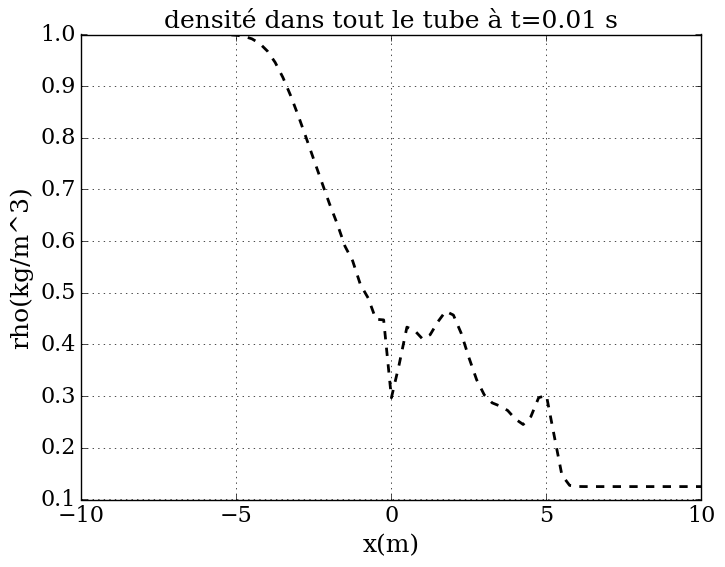

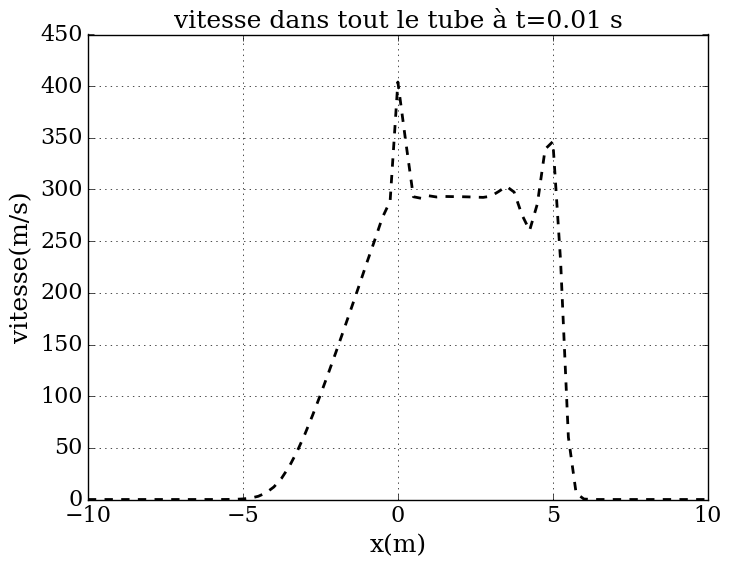

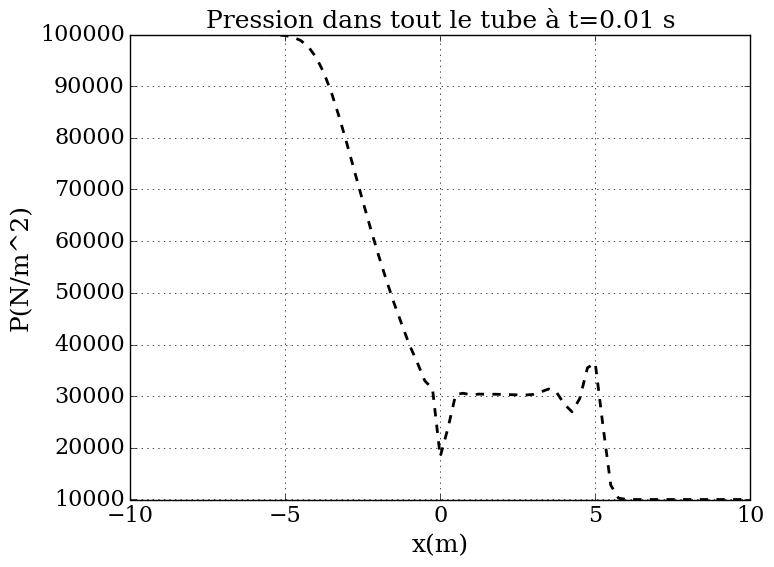

In [10]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x(m)', fontsize=18)
pyplot.ylabel(r'rho(kg/m^3)', fontsize=18)
pyplot.title('densité dans tout le tube à t=0.01 s', fontsize=18)
pyplot.plot(x,Gdensite, 'k--', lw=2)

pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x(m)', fontsize=18)
pyplot.ylabel(r'vitesse(m/s)', fontsize=18)
pyplot.title('vitesse dans tout le tube à t=0.01 s', fontsize=18)
pyplot.plot(x,Gvitesse, 'k--', lw=2)

pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x(m)', fontsize=18)
pyplot.ylabel(r'P(N/m^2)', fontsize=18)
pyplot.title('Pression dans tout le tube à t=0.01 s', fontsize=18)
pyplot.plot(x,Gpression, 'k--', lw=2)

Ces trois graphiques nous montrent presque ce que nous voulions. Presque, parce que nous voyons à chaque fois  un pic en 0 ainsi qu'un deuxième pic légèrement précédé d'un troisième pic vers la position 5. Nous pensons que cela n'est pas dû à la physique présente dans le tyau mais plutôt à la méthode utilisée qui n'est pas assez précise. Le pic en zéro serait dû au changement trop "brutal" qui se produit en zéro, c'est l'entre deux milieu, là où se trouvait la membrane. Nous avons alors à cet endroit des données difficilement calculable avec précision.  Le deuxième pic est pour nous là où se trouve le choc au moment donné. 

Vu que c'est un choc qui se propage, mais qu'on ne voit qu'un pic lors d'un graphique pour un temps donné, nos avons décidé de faire trois animations, à nouveau une pour chaque donnée étudiée. 

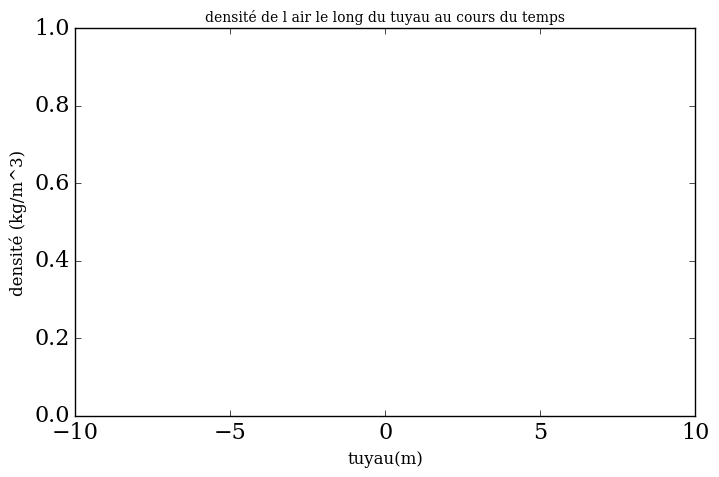

In [11]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0,1))
line = ax.plot([], [], color='#803366', ls='--', lw=3)[0]
pyplot.xlabel(r'tuyau(m)', fontsize=12)
pyplot.ylabel(r'densité (kg/m^3)', fontsize=12)
pyplot.title('densité de l air le long du tuyau au cours du temps', fontsize=10)

In [12]:
U=U0.copy()
Udemi=np.zeros((80, 3)) #les matrices demi ont un élément de moins que les matrices U et F
Fdemi=np.zeros((80,3))
F=np.zeros((81, 3))
for l in range(81):
    F[l]=f(U0[l])
densite=np.zeros(81)
densite[0]=IC[0][0]   #on les fixe manuellement car l'etat du systeme au bord est invariant par rapport au temps
densite[80]=IC[80][0] 
def densi(i):
    line.set_data(x,densite)
    
    Uc=U.copy()
    for j in range(80):
         for k in range(3):
            Udemi[j][k]=((U[j+1][k]+U[j][k])/2.0)-((dt/(2.0*dx))*(F[j+1][k]-F[j][k]))
    for l in range(80):
        Fdemi[l]=f(Udemi[l])
    for j in range(1,80):
        for k in range(3):
            U[j][k]=Uc[j][k]-((dt/dx)*(Fdemi[j][k]-Fdemi[j-1][k]))
        densite[j]=Uc[j][0]
    for l in range(0,80):
        F[l]=f(U[l])
        
anim = animation.FuncAnimation(fig, densi,
                               frames=60, interval=60)
HTML(anim.to_html5_video())

RuntimeError: No MovieWriters available!

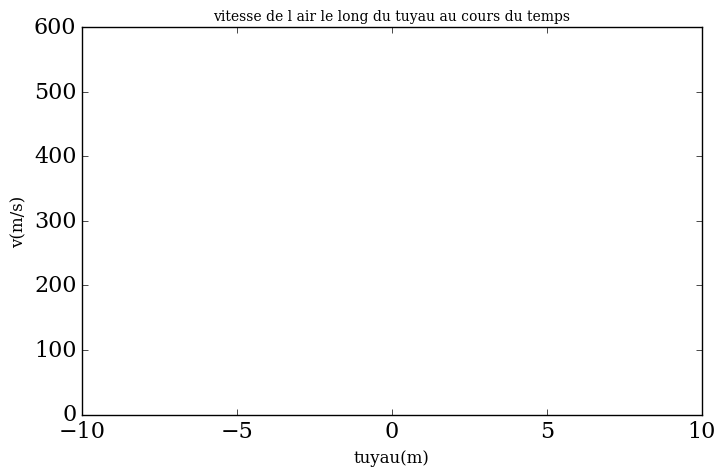

In [14]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0,600))
line = ax.plot([], [], color='#803366', ls='--', lw=3)[0]
pyplot.xlabel(r'tuyau(m)', fontsize=12)
pyplot.ylabel(r'v(m/s)', fontsize=12)
pyplot.title('vitesse de l air le long du tuyau au cours du temps', fontsize=10)

In [ ]:
U=U0.copy()
Udemi=np.zeros((80, 3)) #les matrices demi ont un élément de moins que les matrices U et F
Fdemi=np.zeros((80,3))
F=np.zeros((81, 3))
for l in range(81):
    F[l]=f(U0[l])

vitesse=np.zeros(81)
vitesse[80]=IC[80][1]
vitesse[0]=IC[0][1]

def vit(i):
    line.set_data(x,vitesse)
    
    Uc=U.copy()
    
    for j in range(80):
         for k in range(3):
            Udemi[j][k]=((U[j+1][k]+U[j][k])/2.0)-((dt/(2.0*dx))*(F[j+1][k]-F[j][k]))
    for l in range(80):
        Fdemi[l]=f(Udemi[l])
    for j in range(1,80):
        for k in range(3):
            U[j][k]=Uc[j][k]-((dt/dx)*(Fdemi[j][k]-Fdemi[j-1][k]))
        vitesse[j]=Uc[j][1]/Uc[j][0]
    for l in range(0,80):
        F[l]=f(U[l])
        
        
anim = animation.FuncAnimation(fig, vit,
                               frames=60, interval=60)
HTML(anim.to_html5_video())

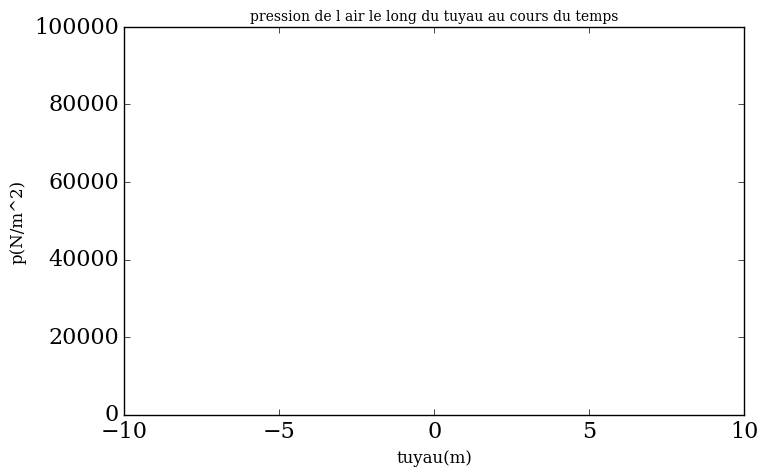

In [15]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0,100000))

line = ax.plot([], [], color='#803366', ls='--', lw=3)[0]
pyplot.xlabel(r'tuyau(m)', fontsize=12)
pyplot.ylabel(r'p(N/m^2)', fontsize=12)
pyplot.title('pression de l air le long du tuyau au cours du temps', fontsize=10)

In [13]:
U=U0.copy()
Udemi=np.zeros((80, 3)) #les matrices demi ont un élément de moins que les matrices U et F
Fdemi=np.zeros((80,3))
F=np.zeros((81, 3))
for l in range(81):
    F[l]=f(U0[l])

pression=np.zeros(81)
pression[0]=IC[0][2]
pression[80]=IC[80][2]
def press(i):
    line.set_data(x,pression)
    
    Uc=U.copy()
    
    for j in range(80):
         for k in range(3):
            Udemi[j][k]=((U[j+1][k]+U[j][k])/2.0)-((dt/(2.0*dx))*(F[j+1][k]-F[j][k]))
    for l in range(80):
        Fdemi[l]=f(Udemi[l])
    for j in range(1,80):
        for k in range(3):
            U[j][k]=Uc[j][k]-((dt/dx)*(Fdemi[j][k]-Fdemi[j-1][k]))
        pression[j]=(gamma-1)*(Uc[j][2]-((Uc[j][1])**2/Uc[j][0])/2.0)
    for l in range(80):
        F[l]=f(U[l])
        
                               
anim = animation.FuncAnimation(fig, press,
                               frames=60, interval=60)
HTML(anim.to_html5_video())

RuntimeError: No MovieWriters available!

Les graphiques nous montrent bien ce que nous attendions. Nous pouvons bien voir le choc partir du centre et se propager vers la droite. Si on augmete la valeur "frame", on aura une animation qui durera plus longtemps. Au bout d'un temps suffisament long, nous avons davantage de dégénérescences. Celles-ci sont surement du au fait que le choc atteind le bord.  

Pour conclure ce travail, nous voyons que la méthode de Richtmyer est pas mal pour calculer un problème tel que celui-ci, mais a tout de même ses limites comme nos avons pu le constater via les pics sur les graphiques ou encore pas les trop grandes imprécisions pour un temps trop long. 